In [1]:
# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import logging
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Load the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")  # Replace with your dataset path
df = df[['Text', 'Category']]  # Focus on only one task: Category classification
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

# Load Bengali stopwords
try:
    stop_words = set(nltk.corpus.stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bengali characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    if stop_words:
        words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# -------------------------------
# 2. Upsampling to Balance Classes
# -------------------------------

def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df_upsampled = upsample(df, 'Category')

# Encode labels
category_encoder = LabelEncoder()
df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Category'])

# -------------------------------
# 3. Tokenization using BERT
# -------------------------------

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)


# Create window-based adjacency matrices
def window_based_adjacency(sentences, window_size=2, max_len=20):
    adjacency_matrices = []
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        adjacency_matrices.append(adj)
    return np.array(adjacency_matrices, dtype=np.float32)

adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)


# -------------------------------
# 4. Data Splitting
# -------------------------------

# Split the data
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category = train_test_split(
    input_ids, attention_masks, adjacency_matrices,  df_upsampled['Category_encoded'].values,
    test_size=0.2, random_state=42, stratify=df_upsampled['Category_encoded'].values
)

f:\Mini Conda\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initial DataFrame:
                                                Text                 Category
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।                  service
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...                     food
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  anecdotes/miscellaneous
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...                     food
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...                  service
Initial Data Shape: (2059, 2)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DataFrame after text cleaning:
                                                Text                 Category
0                                       স্টাফ ভয়ঙ্কর                  service
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...                     food
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  anecdotes/miscellaneous
3  খাবার একদমই ব্যতিক্রমী সক্ষম রান্নাঘর গর্বের খ...                     food
4  গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা আপনাকে খেতে...                  service


f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 111/111 [00:01<00:00, 65.47it/s] 


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Embedding, Flatten, Layer
from tensorflow.keras.models import Model
from spektral.layers import GATConv
from transformers import TFBertModel
import numpy as np

# Squash function for Capsule Networks
def squash(vectors):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    unit_vectors = vectors / tf.sqrt(s_squared_norm + 1e-9)
    return scale * unit_vectors

# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

# GNNContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_heads=8, max_len=20, dropout_rate=0.2, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        # Positional Encoding
        self.position_embedding = Embedding(input_dim=max_len, output_dim=hidden_size)

        # Multi-Head GAT Layers
        self.gat_layers = [GATConv(hidden_size // num_heads, activation='elu') for _ in range(num_heads)]
        self.concat = Concatenate()

        # Highway Network for Modulation
        self.transform_gate = Dense(hidden_size, activation='sigmoid')
        self.carry_gate = Dense(hidden_size, activation='sigmoid')

        # Dropout and Layer Norm
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

        # Dense layer for resonance scores
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, adjacency, edge_features=None, training=False):
        position_indices = tf.range(self.max_len)[tf.newaxis, :]
        position_embeddings = self.position_embedding(position_indices)
        inputs = inputs + position_embeddings

        gat_outputs = []
        for gat_layer in self.gat_layers:
            x = gat_layer([inputs, adjacency])
            gat_outputs.append(x)
        x = self.concat(gat_outputs)

        # Residual Connection
        x = x + inputs

        # Highway Network for Modulation
        transform = self.transform_gate(x)
        carry = self.carry_gate(inputs)
        outputs = transform * x + (1 - transform) * carry

        # Apply dropout and layer normalization
        outputs = self.dropout(outputs, training=training)
        outputs = self.layer_norm(outputs)

        resonance_scores = self.dense(outputs)

        return outputs, resonance_scores

# Building the Model with BERT and GNN for Single Task (Category)
def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # BERT output

    # Apply GNN-Based Context Resonance
    gnn_resonance_layer = GNNContextResonance(hidden_size, num_heads=8, max_len=max_len)
    gnn_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)

    # Implement Dual Attention Mechanism (Self-attention and Cross-attention)
    self_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    self_attention_output, self_attention_scores = self_attention_layer([gnn_output, gnn_output, gnn_output])

    cross_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    cross_attention_output, cross_attention_scores = cross_attention_layer([sequence_output, gnn_output, gnn_output])

    # Combine outputs
    combined_output = Concatenate(axis=-1)([self_attention_output, cross_attention_output])

    # Capsule Networks Layer
    caps_num_capsules = 10  # Number of capsules
    caps_dim_capsules = 16  # Dimension of each capsule

    primary_capsules = tf.keras.layers.Conv1D(
        filters=caps_num_capsules * caps_dim_capsules,
        kernel_size=1,
        strides=1,
        padding='valid'
    )(combined_output)

    primary_capsules = tf.keras.layers.Reshape(
        target_shape=(max_len, caps_num_capsules, caps_dim_capsules)
    )(primary_capsules)

    primary_capsules = tf.keras.layers.Lambda(squash, name='primary_caps_squash')(primary_capsules)

    flat_capsules = Flatten()(primary_capsules)

    dropout = Dropout(0.3)(flat_capsules)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Model will only output Category and resonance scores
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, resonance_scores]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                            

In [3]:
# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss function for category classification without class weights
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')

# Define the supervised contrastive loss function
def supervised_contrastive_loss(labels, features, temperature=0.1):
    labels = tf.reshape(labels, [-1])
    label_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    logits_max = tf.reduce_max(similarity_matrix, axis=1, keepdims=True)
    logits = similarity_matrix - logits_max
    exp_logits = tf.exp(logits) * tf.cast(label_mask, tf.float32)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)
    mean_log_prob_pos = tf.reduce_sum(log_prob * tf.cast(label_mask, tf.float32), axis=1) / tf.reduce_sum(tf.cast(label_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

# -------------------------------
# 4. Custom Training Loop
# -------------------------------
@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks, adjacency], training=True)
        predictions_category = predictions[0]
        resonance_scores = predictions[1]  # Resonance scores (if needed for other tasks)

        # Compute per-sample standard loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute smoothness loss (if required by your architecture)
        resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1, 2])  # (batch_size,)
        smoothness_loss = tf.reduce_mean(smoothness_loss)

        # Remove contrastive loss (since features aren't being returned)
        total_loss = tf.reduce_mean(cce_loss_category) + smoothness_loss

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)

    return total_loss, cce_loss_category, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category):
    # Forward pass
    predictions = model([input_ids, attention_masks, adjacency], training=False)
    predictions_category = predictions[0]
    resonance_scores = predictions[1]

    # Compute per-sample standard loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute smoothness loss (if required by your architecture)
    resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)
    resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1, 2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)

    # Remove contrastive loss (since features aren't being returned)
    total_loss = tf.reduce_mean(cce_loss_category) + smoothness_loss

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)

    return total_loss, cce_loss_category, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 20
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': X_train_ids,
    'attention_masks': X_train_masks,
    'adjacency': adjacency_train
}, y_train_category)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': X_test_ids,
    'attention_masks': X_test_masks,
    'adjacency': adjacency_test
}, y_test_category)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_smoothness_loss': [],
    'train_accuracy_category': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_smoothness_loss': [],
    'val_accuracy_category': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
import time
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch + 1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    val_accuracy_category.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
    
        # Unpack only 3 values, since the train_step now returns 3 values
        total_loss, cce_loss_cat, smoothness_loss = train_step(
            input_ids, attention_masks, adjacency, labels_category)
    
        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        smoothness_loss_avg.update_state(smoothness_loss)
    
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"Smoothness Loss = {smoothness_loss_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
    
        # Unpack only 3 values, since the test_step now returns 3 values
        total_loss, cce_loss_cat, smoothness_loss = test_step(
            input_ids, attention_masks, adjacency, labels_category)
    
        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_smoothness_loss_avg.update_state(smoothness_loss)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")



Start of epoch 1
Step 0: Total Loss = 3.6809, CCE Loss Category = 1.7454, Smoothness Loss = 1.9355, Train Accuracy Category = 0.1250
Step 100: Total Loss = 1.6199, CCE Loss Category = 1.5909, Smoothness Loss = 0.0291, Train Accuracy Category = 0.2525
Epoch 1 Training Loss: 1.5383
Epoch 1 Training CCE Loss Category: 1.5212
Epoch 1 Training Smoothness Loss: 0.0171
Epoch 1 Training Accuracy Category: 0.3137
Epoch 1 Validation Loss: 1.3205
Epoch 1 Validation CCE Loss Category: 1.3183
Epoch 1 Validation Smoothness Loss: 0.0003
Epoch 1 Validation Accuracy Category: 0.4676
Epoch 1 Duration: 51.17 seconds

Start of epoch 2
Step 0: Total Loss = 1.5031, CCE Loss Category = 1.5022, Smoothness Loss = 0.0009, Train Accuracy Category = 0.3125
Step 100: Total Loss = 1.1375, CCE Loss Category = 1.1365, Smoothness Loss = 0.0009, Train Accuracy Category = 0.5681
Epoch 2 Training Loss: 1.0696
Epoch 2 Training CCE Loss Category: 1.0685
Epoch 2 Training Smoothness Loss: 0.0007
Epoch 2 Training Accuracy Ca

In [4]:
import tensorflow as tf

def compute_macro_precision(y_true, y_pred, num_classes):
    # Calculate precision for each class
    precision_per_class = tf.keras.metrics.Precision(class_id=None, num_classes=num_classes)
    precision_per_class.update_state(y_true, y_pred)
    precision = precision_per_class.result().numpy()
    return precision

def compute_macro_recall(y_true, y_pred, num_classes):
    # Calculate recall for each class
    recall_per_class = tf.keras.metrics.Recall(class_id=None, num_classes=num_classes)
    recall_per_class.update_state(y_true, y_pred)
    recall = recall_per_class.result().numpy()
    return recall

def compute_macro_f1(y_true, y_pred, num_classes):
    # Calculate F1 score for each class
    precision = compute_macro_precision(y_true, y_pred, num_classes)
    recall = compute_macro_recall(y_true, y_pred, num_classes)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1


1/1 [==============================] - 0s 104ms/step
Test Accuracy (Category): 0.7577
Test Macro F1 Score (Category): 0.7542
Test Macro Precision (Category): 0.7596
Test Macro Recall (Category): 0.7577


<Figure size 400x400 with 0 Axes>

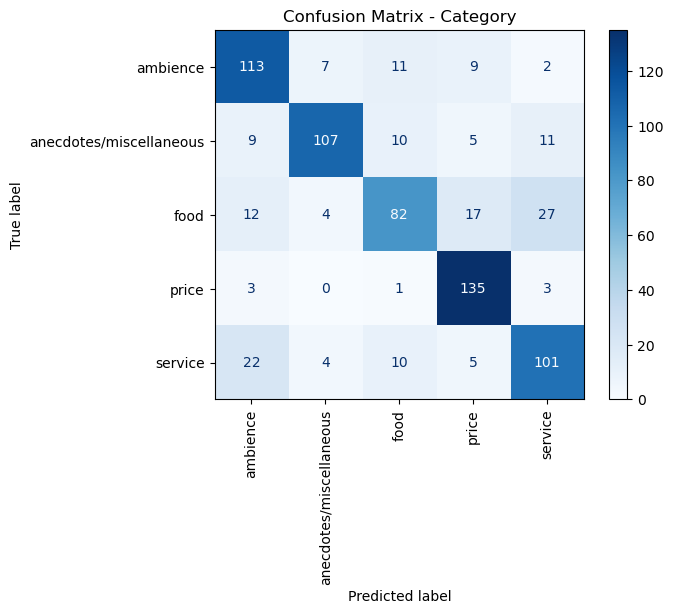

In [5]:
# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_labels_category = []
all_resonance_scores = []

for batch_inputs, batch_labels_category in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    predictions_category = predictions[0]
    resonance_scores = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_labels_category.extend(batch_labels_category.numpy())
    all_resonance_scores.extend(resonance_scores)

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Confusion Matrix for Category
plt.figure(figsize=(4, 4))
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title('Confusion Matrix - Category')
plt.show()


Initial DataFrame:
                                                Text  Polarity
0              স্টাফ কিন্তু, আমাদের জন্য ভয়ঙ্কর ছিল।  negative
1  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  positive
2  শুধুমাত্র,রিডামিং ফ্যাক্টর খাদ্য ছিল,পুরোপুরি ...  negative
3  খাবার একদমই ব্যতিক্রমী, একটি খুব সক্ষম রান্নাঘ...  positive
4  যেখানে গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা জানা...  positive
Initial Data Shape: (2059, 2)
DataFrame after text cleaning:
                                                Text  Polarity
0                                       স্টাফ ভয়ঙ্কর  negative
1  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  positive
2  শুধুমাত্ররিডামিং ফ্যাক্টর খাদ্য ছিলপুরোপুরি ন্...  negative
3  খাবার একদমই ব্যতিক্রমী সক্ষম রান্নাঘর গর্বের খ...  positive
4  গাব্রিয়েলা লোকালি আপনাকে শুভেচ্ছা আপনাকে খেতে...  positive


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhose\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
f:\Mini Conda\envs\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tokenizing: 100%|██████████| 153/153 [00:01<00:00, 103.57it/s]
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are ini

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 20)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 20)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 20,                                          

<Figure size 400x400 with 0 Axes>

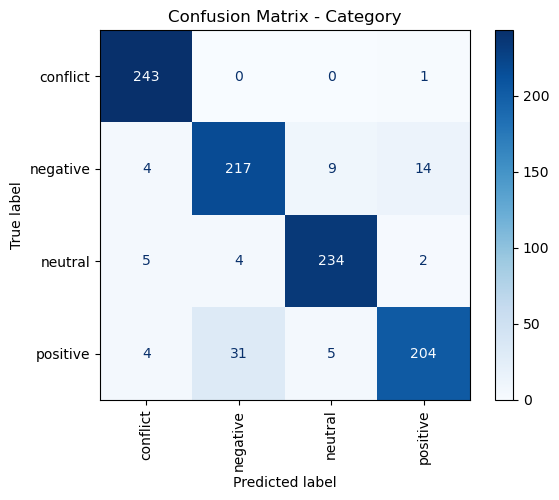

In [6]:
# -------------------------------
# 0. Environment Setup
# -------------------------------

# Set random seeds for reproducibility
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import logging
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

# Suppress TensorFlow warnings for cleaner output
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Load the dataset
df = pd.read_csv(r"F:\Context-Resonance Transformer\Restuarant\Restaurant - Sheet1.csv")  # Replace with your dataset path
df = df[['Text', 'Polarity']]  # Focus on only one task: Category classification
print("Initial DataFrame:")
print(df.head())
print(f"Initial Data Shape: {df.shape}")

# Initialize Bengali stopwords
nltk.download('stopwords')

# Load Bengali stopwords
try:
    stop_words = set(nltk.corpus.stopwords.words('bengali'))
except LookupError:
    print("Bengali stopwords not found. Skipping stopword removal.")
    stop_words = set()

# Function to clean text
def clean_text(text):
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bengali characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    if stop_words:
        words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

df['Text'] = df['Text'].apply(clean_text)
print("DataFrame after text cleaning:")
print(df.head())

# -------------------------------
# 2. Upsampling to Balance Classes
# -------------------------------

def upsample(df, target_column):
    max_count = df[target_column].value_counts().max()
    upsampled_dfs = []
    for label in df[target_column].unique():
        df_label = df[df[target_column] == label]
        df_upsampled = resample(
            df_label,
            replace=True,
            n_samples=max_count,
            random_state=42
        )
        upsampled_dfs.append(df_upsampled)
    return pd.concat(upsampled_dfs)

df_upsampled = upsample(df, 'Polarity')

# Encode labels
category_encoder = LabelEncoder()
df_upsampled['Category_encoded'] = category_encoder.fit_transform(df_upsampled['Polarity'])

# -------------------------------
# 3. Tokenization using BERT
# -------------------------------

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_sentences(sentences, tokenizer, max_len=20, batch_size=32):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Tokenizing"):
        batch = sentences[i:i+batch_size]
        encoded = tokenizer(
            list(batch),
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    input_ids = tf.concat(input_ids, axis=0).numpy()
    attention_masks = tf.concat(attention_masks, axis=0).numpy()
    return input_ids, attention_masks

# Tokenize the data
input_ids, attention_masks = tokenize_sentences(df_upsampled['Text'].values, tokenizer, max_len=20, batch_size=32)


# Create window-based adjacency matrices
def window_based_adjacency(sentences, window_size=2, max_len=20):
    adjacency_matrices = []
    for sentence in sentences:
        tokens = sentence.split()[:max_len]
        num_tokens = len(tokens)
        adj = np.zeros((max_len, max_len), dtype=np.float32)
        for i in range(num_tokens):
            for j in range(max(i - window_size, 0), min(i + window_size + 1, num_tokens)):
                if i != j:
                    adj[i, j] = 1.0
        adjacency_matrices.append(adj)
    return np.array(adjacency_matrices, dtype=np.float32)

adjacency_matrices = window_based_adjacency(df_upsampled['Text'].values, window_size=2, max_len=20)


# -------------------------------
# 4. Data Splitting
# -------------------------------

# Split the data
X_train_ids, X_test_ids, X_train_masks, X_test_masks, adjacency_train, adjacency_test, y_train_category, y_test_category = train_test_split(
    input_ids, attention_masks, adjacency_matrices,  df_upsampled['Category_encoded'].values,
    test_size=0.2, random_state=42, stratify=df_upsampled['Category_encoded'].values
)
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, Concatenate, Embedding, Flatten, Layer
from tensorflow.keras.models import Model
from spektral.layers import GATConv
from transformers import TFBertModel
import numpy as np

# Squash function for Capsule Networks
def squash(vectors):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    unit_vectors = vectors / tf.sqrt(s_squared_norm + 1e-9)
    return scale * unit_vectors

# Custom Multi-Head Attention Layer
class CustomMultiHeadAttention(Layer):
    def __init__(self, num_heads, key_dim, max_len, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim // num_heads
        self.max_len = max_len

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        else:
            q_shape = input_shape
            k_shape = input_shape
            v_shape = input_shape
        self.wq = self.add_weight(shape=(q_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wk = self.add_weight(shape=(k_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        self.wv = self.add_weight(shape=(v_shape[-1], self.key_dim), initializer='random_normal', trainable=True)
        super(CustomMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.max_len, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # (batch_size, num_heads, seq_len, depth)

    def call(self, inputs, mask=None):
        if isinstance(inputs, list) and len(inputs) == 3:
            q, k, v = inputs
        else:
            q = inputs
            k = inputs
            v = inputs
        batch_size = tf.shape(q)[0]

        q = tf.matmul(q, self.wq)
        k = tf.matmul(k, self.wk)
        v = tf.matmul(v, self.wv)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        # Scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, self.max_len, self.key_dim))

        # Set shapes for Keras
        concat_attention.set_shape((None, self.max_len, self.key_dim))
        attention_weights.set_shape((None, self.num_heads, self.max_len, self.max_len))

        return concat_attention, attention_weights

# GNNContextResonance Layer
class GNNContextResonance(tf.keras.layers.Layer):
    def __init__(self, hidden_size, num_heads=8, max_len=20, dropout_rate=0.2, **kwargs):
        super(GNNContextResonance, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.max_len = max_len
        self.dropout_rate = dropout_rate

        # Positional Encoding
        self.position_embedding = Embedding(input_dim=max_len, output_dim=hidden_size)

        # Multi-Head GAT Layers
        self.gat_layers = [GATConv(hidden_size // num_heads, activation='elu') for _ in range(num_heads)]
        self.concat = Concatenate()

        # Highway Network for Modulation
        self.transform_gate = Dense(hidden_size, activation='sigmoid')
        self.carry_gate = Dense(hidden_size, activation='sigmoid')

        # Dropout and Layer Norm
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

        # Dense layer for resonance scores
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, adjacency, edge_features=None, training=False):
        position_indices = tf.range(self.max_len)[tf.newaxis, :]
        position_embeddings = self.position_embedding(position_indices)
        inputs = inputs + position_embeddings

        gat_outputs = []
        for gat_layer in self.gat_layers:
            x = gat_layer([inputs, adjacency])
            gat_outputs.append(x)
        x = self.concat(gat_outputs)

        # Residual Connection
        x = x + inputs

        # Highway Network for Modulation
        transform = self.transform_gate(x)
        carry = self.carry_gate(inputs)
        outputs = transform * x + (1 - transform) * carry

        # Apply dropout and layer normalization
        outputs = self.dropout(outputs, training=training)
        outputs = self.layer_norm(outputs)

        resonance_scores = self.dense(outputs)

        return outputs, resonance_scores

# Building the Model with BERT and GNN for Single Task (Category)
def build_model_with_gnn(bert_model, hidden_size, max_len=20):
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_masks = Input(shape=(max_len,), dtype=tf.int32, name='attention_masks')
    adjacency = Input(shape=(max_len, max_len), dtype=tf.float32, name='adjacency')

    # Get BERT embeddings
    bert_outputs = bert_model([input_ids, attention_masks])
    sequence_output = bert_outputs.last_hidden_state  # BERT output

    # Apply GNN-Based Context Resonance
    gnn_resonance_layer = GNNContextResonance(hidden_size, num_heads=8, max_len=max_len)
    gnn_output, resonance_scores = gnn_resonance_layer(sequence_output, adjacency)

    # Implement Dual Attention Mechanism (Self-attention and Cross-attention)
    self_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    self_attention_output, self_attention_scores = self_attention_layer([gnn_output, gnn_output, gnn_output])

    cross_attention_layer = CustomMultiHeadAttention(num_heads=8, key_dim=hidden_size, max_len=max_len)
    cross_attention_output, cross_attention_scores = cross_attention_layer([sequence_output, gnn_output, gnn_output])

    # Combine outputs
    combined_output = Concatenate(axis=-1)([self_attention_output, cross_attention_output])

    # Capsule Networks Layer
    caps_num_capsules = 10  # Number of capsules
    caps_dim_capsules = 16  # Dimension of each capsule

    primary_capsules = tf.keras.layers.Conv1D(
        filters=caps_num_capsules * caps_dim_capsules,
        kernel_size=1,
        strides=1,
        padding='valid'
    )(combined_output)

    primary_capsules = tf.keras.layers.Reshape(
        target_shape=(max_len, caps_num_capsules, caps_dim_capsules)
    )(primary_capsules)

    primary_capsules = tf.keras.layers.Lambda(squash, name='primary_caps_squash')(primary_capsules)

    flat_capsules = Flatten()(primary_capsules)

    dropout = Dropout(0.3)(flat_capsules)

    # Category Output
    category_output = Dense(len(category_encoder.classes_), activation='softmax', name='category_output')(dropout)

    # Model will only output Category and resonance scores
    model = Model(
        inputs=[input_ids, attention_masks, adjacency],
        outputs=[category_output, resonance_scores]
    )

    return model

# Load pre-trained multilingual BERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')
hidden_size = bert_model.config.hidden_size  # Typically 768

# Build the model
model = build_model_with_gnn(bert_model, hidden_size, max_len=20)

# Summary of the model
model.summary()

# -------------------------------
# 3. Defining Custom Loss Functions and Metrics
# -------------------------------

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Define the standard loss function for category classification without class weights
loss_fn_category = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

# Define metrics
train_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy_category')
val_accuracy_category = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy_category')

# Define the supervised contrastive loss function
def supervised_contrastive_loss(labels, features, temperature=0.1):
    labels = tf.reshape(labels, [-1])
    label_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    features = tf.math.l2_normalize(features, axis=1)
    similarity_matrix = tf.matmul(features, features, transpose_b=True) / temperature
    logits_max = tf.reduce_max(similarity_matrix, axis=1, keepdims=True)
    logits = similarity_matrix - logits_max
    exp_logits = tf.exp(logits) * tf.cast(label_mask, tf.float32)
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True) + 1e-8)
    mean_log_prob_pos = tf.reduce_sum(log_prob * tf.cast(label_mask, tf.float32), axis=1) / tf.reduce_sum(tf.cast(label_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(mean_log_prob_pos)
    return loss

# -------------------------------
# 4. Custom Training Loop
# -------------------------------
@tf.function
def train_step(input_ids, attention_masks, adjacency, labels_category):
    with tf.GradientTape() as tape:
        # Forward pass
        predictions = model([input_ids, attention_masks, adjacency], training=True)
        predictions_category = predictions[0]
        resonance_scores = predictions[1]  # Resonance scores (if needed for other tasks)

        # Compute per-sample standard loss for category
        cce_loss_category = loss_fn_category(labels_category, predictions_category)

        # Compute smoothness loss (if required by your architecture)
        resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)  # (batch_size, seq_length)
        resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
        squared_diff = tf.square(resonance_diff)
        smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1, 2])  # (batch_size,)
        smoothness_loss = tf.reduce_mean(smoothness_loss)

        # Remove contrastive loss (since features aren't being returned)
        total_loss = tf.reduce_mean(cce_loss_category) + smoothness_loss

    # Compute gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)

    # Update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update metrics
    train_accuracy_category.update_state(labels_category, predictions_category)

    return total_loss, cce_loss_category, smoothness_loss

@tf.function
def test_step(input_ids, attention_masks, adjacency, labels_category):
    # Forward pass
    predictions = model([input_ids, attention_masks, adjacency], training=False)
    predictions_category = predictions[0]
    resonance_scores = predictions[1]

    # Compute per-sample standard loss for category
    cce_loss_category = loss_fn_category(labels_category, predictions_category)

    # Compute smoothness loss (if required by your architecture)
    resonance_scores_squeezed = tf.squeeze(resonance_scores, axis=-1)
    resonance_diff = resonance_scores_squeezed[:, :, tf.newaxis] - resonance_scores_squeezed[:, tf.newaxis, :]
    squared_diff = tf.square(resonance_diff)
    smoothness_loss = tf.reduce_sum(adjacency * squared_diff, axis=[1, 2])
    smoothness_loss = tf.reduce_mean(smoothness_loss)

    # Remove contrastive loss (since features aren't being returned)
    total_loss = tf.reduce_mean(cce_loss_category) + smoothness_loss

    # Update metrics
    val_accuracy_category.update_state(labels_category, predictions_category)

    return total_loss, cce_loss_category, smoothness_loss

# -------------------------------
# 5. Training the Model
# -------------------------------

epochs = 20
batch_size = 16

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': X_train_ids,
    'attention_masks': X_train_masks,
    'adjacency': adjacency_train
}, y_train_category)).shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(({
    'input_ids': X_test_ids,
    'attention_masks': X_test_masks,
    'adjacency': adjacency_test
}, y_test_category)).batch(batch_size)

# Initialize history dictionaries
history = {
    'train_loss': [],
    'train_cce_loss_category': [],
    'train_smoothness_loss': [],
    'train_accuracy_category': [],
    'val_loss': [],
    'val_cce_loss_category': [],
    'val_smoothness_loss': [],
    'val_accuracy_category': [],
    'epoch_time': []  # Added to record time per epoch
}

# Start time of training
import time
training_start_time = time.time()

# Training Loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch + 1}")
    epoch_start_time = time.time()  # Record start time of the epoch

    # Reset metrics at the start of each epoch
    train_accuracy_category.reset_states()
    val_accuracy_category.reset_states()

    # Training
    total_loss_avg = tf.keras.metrics.Mean()
    cce_loss_category_avg = tf.keras.metrics.Mean()
    smoothness_loss_avg = tf.keras.metrics.Mean()

    for step, (batch_inputs, batch_labels_category) in enumerate(train_dataset):
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
    
        # Unpack only 3 values, since the train_step now returns 3 values
        total_loss, cce_loss_cat, smoothness_loss = train_step(
            input_ids, attention_masks, adjacency, labels_category)
    
        total_loss_avg.update_state(total_loss)
        cce_loss_category_avg.update_state(cce_loss_cat)
        smoothness_loss_avg.update_state(smoothness_loss)
    
        if step % 100 == 0:
            print(f"Step {step}: Total Loss = {total_loss_avg.result():.4f}, "
                  f"CCE Loss Category = {cce_loss_category_avg.result():.4f}, "
                  f"Smoothness Loss = {smoothness_loss_avg.result():.4f}, "
                  f"Train Accuracy Category = {train_accuracy_category.result():.4f}")

    # Record training metrics
    history['train_loss'].append(total_loss_avg.result().numpy())
    history['train_cce_loss_category'].append(cce_loss_category_avg.result().numpy())
    history['train_smoothness_loss'].append(smoothness_loss_avg.result().numpy())
    history['train_accuracy_category'].append(train_accuracy_category.result().numpy())

    print(f"Epoch {epoch+1} Training Loss: {total_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training CCE Loss Category: {cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Smoothness Loss: {smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Training Accuracy Category: {train_accuracy_category.result():.4f}")

    # Validation
    val_loss_avg = tf.keras.metrics.Mean()
    val_cce_loss_category_avg = tf.keras.metrics.Mean()
    val_smoothness_loss_avg = tf.keras.metrics.Mean()

    for batch_inputs, batch_labels_category in test_dataset:
        input_ids = batch_inputs['input_ids']
        attention_masks = batch_inputs['attention_masks']
        adjacency = batch_inputs['adjacency']
        labels_category = batch_labels_category
    
        # Unpack only 3 values, since the test_step now returns 3 values
        total_loss, cce_loss_cat, smoothness_loss = test_step(
            input_ids, attention_masks, adjacency, labels_category)
    
        val_loss_avg.update_state(total_loss)
        val_cce_loss_category_avg.update_state(cce_loss_cat)
        val_smoothness_loss_avg.update_state(smoothness_loss)

    # Record validation metrics
    history['val_loss'].append(val_loss_avg.result().numpy())
    history['val_cce_loss_category'].append(val_cce_loss_category_avg.result().numpy())
    history['val_smoothness_loss'].append(val_smoothness_loss_avg.result().numpy())
    history['val_accuracy_category'].append(val_accuracy_category.result().numpy())

    print(f"Epoch {epoch+1} Validation Loss: {val_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation CCE Loss Category: {val_cce_loss_category_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Smoothness Loss: {val_smoothness_loss_avg.result():.4f}")
    print(f"Epoch {epoch+1} Validation Accuracy Category: {val_accuracy_category.result():.4f}")

    # Calculate epoch duration
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    history['epoch_time'].append(epoch_duration)
    print(f"Epoch {epoch+1} Duration: {epoch_duration:.2f} seconds")

# Total training time
training_end_time = time.time()
total_training_time = training_end_time - training_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

import tensorflow as tf

def compute_macro_precision(y_true, y_pred, num_classes):
    # Calculate precision for each class
    precision_per_class = tf.keras.metrics.Precision(class_id=None, num_classes=num_classes)
    precision_per_class.update_state(y_true, y_pred)
    precision = precision_per_class.result().numpy()
    return precision

def compute_macro_recall(y_true, y_pred, num_classes):
    # Calculate recall for each class
    recall_per_class = tf.keras.metrics.Recall(class_id=None, num_classes=num_classes)
    recall_per_class.update_state(y_true, y_pred)
    recall = recall_per_class.result().numpy()
    return recall

def compute_macro_f1(y_true, y_pred, num_classes):
    # Calculate F1 score for each class
    precision = compute_macro_precision(y_true, y_pred, num_classes)
    recall = compute_macro_recall(y_true, y_pred, num_classes)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return f1

# -------------------------------
# 6. Evaluation and Visualization
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
all_predictions_category = []
all_labels_category = []
all_resonance_scores = []

for batch_inputs, batch_labels_category in test_dataset:
    input_ids = batch_inputs['input_ids']
    attention_masks = batch_inputs['attention_masks']
    adjacency = batch_inputs['adjacency']

    predictions = model.predict([input_ids, attention_masks, adjacency])
    predictions_category = predictions[0]
    resonance_scores = predictions[1]

    predicted_labels_category = np.argmax(predictions_category, axis=1)

    all_predictions_category.extend(predicted_labels_category)
    all_labels_category.extend(batch_labels_category.numpy())
    all_resonance_scores.extend(resonance_scores)

# Convert lists to numpy arrays
all_labels_category = np.array(all_labels_category)
all_predictions_category = np.array(all_predictions_category)

# Calculate metrics for Category
accuracy_category = accuracy_score(all_labels_category, all_predictions_category)
f1_category = f1_score(all_labels_category, all_predictions_category, average='macro')
precision_category = precision_score(all_labels_category, all_predictions_category, average='macro')
recall_category = recall_score(all_labels_category, all_predictions_category, average='macro')

print(f"Test Accuracy (Category): {accuracy_category:.4f}")
print(f"Test Macro F1 Score (Category): {f1_category:.4f}")
print(f"Test Macro Precision (Category): {precision_category:.4f}")
print(f"Test Macro Recall (Category): {recall_category:.4f}")

# Confusion Matrix for Category
plt.figure(figsize=(4, 4))
cm_category = confusion_matrix(all_labels_category, all_predictions_category)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_category, display_labels=category_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title('Confusion Matrix - Category')
plt.show()

